# 📁 1. Configuración del entorno

In [1]:
# Instalación de dependencias necesarias para el proyecto
!pip install librosa torch torchvision torchaudio scikit-learn matplotlib seaborn tqdm

# Montar Google Drive (opcional, si los datos están en Drive)
# Esto permite al Colab acceder a archivos almacenados en tu Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 🗂️ 2. Configuración de rutas del dataset

In [2]:
# === CONFIGURACIÓN DEL USUARIO ===
# Ruta base donde se encuentra la carpeta 'dataset'
# ¡IMPORTANTE! Asegúrate de cambiar esta ruta para que apunte a la ubicación correcta de tu dataset en Google Drive
BASE_PATH = "/content/drive/MyDrive/2. Investigación y SNI/Proyectos de investigación/devCode Challenge 2025/Code/dataset"  # ← Cambia esta ruta si es necesario

# Nombres de las subcarpetas dentro de 'dataset'
# Estas subcarpetas deben contener los archivos de audio (.wav o .mp3)
FOLDER_FIRE = "fuego"      # Carpeta que contiene audios de fuego
FOLDER_NO_FIRE = "no_fuego"  # Carpeta que contiene audios sin fuego
# =================================


# 🎧 3. Carga y preprocesamiento de los audios

## 3.1. Funciones de utilidad

In [3]:
import os
import librosa
import numpy as np
from tqdm import tqdm

# Parámetros de audio globales utilizados para el preprocesamiento
SAMPLE_RATE = 22050  # Frecuencia de muestreo estándar para audios (Hz)
DURATION = 5  # Duración deseada de cada segmento de audio en segundos
N_MELS = 128         # Número de bandas Mel en el espectrograma Mel
N_FFT = 2048         # Tamaño de la ventana FFT (Fast Fourier Transform)
HOP_LENGTH = 512     # Número de muestras entre frames sucesivos de FFT

def load_and_preprocess_audio(file_path, sr=SAMPLE_RATE, duration=DURATION):
    """
    Carga un archivo de audio y lo trunca o rellena a 'duration' segundos.

    Args:
        file_path (str): Ruta al archivo de audio.
        sr (int): Frecuencia de muestreo.
        duration (int): Duración deseada en segundos.

    Returns:
        np.ndarray: Array NumPy de la señal de audio preprocesada.
    """
    # Cargar el audio usando librosa. `sr=None` carga el audio a su frecuencia original,
    # pero `sr` aquí está establecido a SAMPLE_RATE para resampling automático.
    # `duration` trunca el audio si es más largo.
    y, _ = librosa.load(file_path, sr=sr, duration=duration)

    # Si el audio es más corto que la duración deseada, se rellena con ceros al final.
    if len(y) < sr * duration:
        y = np.pad(y, (0, sr * duration - len(y)), mode='constant')
    return y

def audio_to_melspec(y, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """
    Convierte una señal de audio en un espectrograma Mel en escala logarítmica.

    Args:
        y (np.ndarray): Señal de audio.
        sr (int): Frecuencia de muestreo.
        n_mels (int): Número de bandas Mel.
        n_fft (int): Tamaño de la ventana FFT.
        hop_length (int): Número de muestras entre frames sucesivos.

    Returns:
        np.ndarray: Espectrograma Mel en escala logarítmica (dB).
    """
    # Calcula el espectrograma Mel-frequency cepstral coefficients (MFCCs)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    # Convierte las potencias del espectrograma a decibelios (dB) para una escala más perceptiva.
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

## 3.2. Construcción del conjunto de datos

In [4]:
from pathlib import Path

def build_dataset(base_path, fire_folder, no_fire_folder):
    """
    Construye listas de rutas de archivo y etiquetas para los audios de fuego y no fuego.

    Args:
        base_path (str): Ruta base al directorio del dataset.
        fire_folder (str): Nombre de la carpeta que contiene audios de fuego.
        no_fire_folder (str): Nombre de la carpeta que contiene audios sin fuego.

    Returns:
        tuple: Una tupla que contiene (file_paths, labels),
               donde file_paths es una lista de rutas de archivos de audio
               y labels es una lista de etiquetas (1 para fuego, 0 para no fuego).
    """
    file_paths = []
    labels = []  # 1 = fuego, 0 = no fuego

    # Construir las rutas completas a las carpetas de fuego y no fuego
    fire_path = Path(base_path) / fire_folder
    no_fire_path = Path(base_path) / no_fire_folder

    # Cargar audios de fuego
    # Itera sobre todos los archivos en la carpeta de fuego
    for f in tqdm(list(fire_path.glob("*.*")),
                  desc="Cargando audios de FUEGO"): # tqdm muestra una barra de progreso
        # Verifica que la extensión del archivo sea de audio compatible
        if f.suffix.lower() in ['.wav', '.mp3', '.flac']:
            file_paths.append(str(f)) # Añade la ruta del archivo a la lista
            labels.append(1)          # Asigna la etiqueta 1 (fuego)

    # Cargar audios de no fuego
    # Itera sobre todos los archivos en la carpeta de no fuego
    for f in tqdm(list(no_fire_path.glob("*.*")),
                  desc="Cargando audios de NO FUEGO"): # tqdm muestra una barra de progreso
        # Verifica que la extensión del archivo sea de audio compatible
        if f.suffix.lower() in ['.wav', '.mp3', '.flac']:
            file_paths.append(str(f)) # Añade la ruta del archivo a la lista
            labels.append(0)          # Asigna la etiqueta 0 (no fuego)

    return file_paths, labels

# Ejecutar la función para construir el dataset con las rutas y etiquetas
print("🛠️ Construyendo dataset...")
file_paths, labels = build_dataset(BASE_PATH, FOLDER_FIRE, FOLDER_NO_FIRE)

# Imprimir un resumen de las estadísticas del dataset cargado
print(f"✅ Total de muestras: {len(file_paths)}")
print(f"🔥 Fuego: {sum(labels)} | 🌿 No fuego: {len(labels) - sum(labels)}")

🛠️ Construyendo dataset...


Cargando audios de NO FUEGO: 100%|██████████| 749/749 [00:00<00:00, 197084.92it/s]

✅ Total de muestras: 2198
🔥 Fuego: 1449 | 🌿 No fuego: 749


## 🧪 4. División en conjuntos de entrenamiento, validación y prueba

In [5]:
from sklearn.model_selection import train_test_split

# Dividir el conjunto de datos en entrenamiento+validación y prueba.
# test_size=0.15 significa que el 15% de los datos se usarán para prueba.
# random_state=42 asegura la reproducibilidad de la división.
# stratify=labels asegura que la proporción de clases (fuego/no fuego) sea la misma en todos los splits.
X_temp, X_test, y_temp, y_test = train_test_split(
    file_paths, labels, test_size=0.15, random_state=42, stratify=labels
)

# Luego, dividir el conjunto temporal (entrenamiento+validación) en entrenamiento y validación.
# test_size=0.18 significa que el 18% del conjunto temporal se usará para validación.
# Esto resulta en una división aproximada de 70% entrenamiento, 15% validación, 15% prueba del total original.
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.18, random_state=42, stratify=y_temp
)

# Imprimir los tamaños de cada conjunto para verificar la distribución
print(f"📊 Tamaños:")
print(f"   Entrenamiento: {len(X_train)}")
print(f"   Validación:    {len(X_val)}")
print(f"   Prueba:        {len(X_test)}")

📊 Tamaños:
   Entrenamiento: 1531
   Validación:    337
   Prueba:        330


## 📦 5. Creación de DataLoader para PyTorch

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

# Definición de una clase de Dataset personalizada para PyTorch.
# Esta clase maneja la carga y preprocesamiento de audios de forma perezosa (lazy loading).
class FireAudioDataset(Dataset):
    def __init__(self, file_paths, labels):
        """
        Inicializa el dataset con las rutas de archivo y las etiquetas correspondientes.
        Args:
            file_paths (list): Lista de rutas a los archivos de audio.
            labels (list): Lista de etiquetas (0 o 1).
        """
        self.file_paths = file_paths
        self.labels = labels

    def __len__(self):
        """
        Devuelve el número total de muestras en el dataset.
        """
        return len(self.file_paths)

    def __getitem__(self, idx):
        """
        Carga y preprocesa una muestra específica por su índice.
        Args:
            idx (int): Índice de la muestra.
        Returns:
            tuple: Una tupla que contiene el espectrograma Mel como tensor y la etiqueta como tensor.
        """
        # Cargar y preprocesar el audio usando las funciones definidas previamente
        y = load_and_preprocess_audio(self.file_paths[idx])
        mel = audio_to_melspec(y)
        # Añadir una dimensión de canal al espectrograma Mel (1, H, W) para que sea compatible con las CNN de PyTorch
        mel = np.expand_dims(mel, axis=0)
        # Convertir a tensores de PyTorch con el tipo de dato correcto
        return torch.tensor(mel, dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# Definir el tamaño del lote (batch) para los DataLoaders
BATCH_SIZE = 16

# Crear instancias de FireAudioDataset para los conjuntos de entrenamiento, validación y prueba
train_dataset = FireAudioDataset(X_train, y_train)
val_dataset = FireAudioDataset(X_val, y_val)
test_dataset = FireAudioDataset(X_test, y_test)

# Crear DataLoaders para iterar sobre los datasets en lotes durante el entrenamiento y la evaluación.
# shuffle=True para el entrenamiento mezcla los datos en cada época.
# num_workers=2 permite la carga de datos en paralelo para acelerar el proceso.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("✅ DataLoaders creados.")

✅ DataLoaders creados.


## 🤖 6. Definición del modelo (CNN 2D)

In [7]:
import torch.nn as nn

# Definición del modelo de red neuronal convolucional (CNN) 2D para la detección de fuego.
# Este modelo procesará los espectrogramas Mel que son imágenes de una sola canal.
class FireDetectionCNN(nn.Module):
    def __init__(self, num_classes=2):
        """
        Inicializa la CNN para clasificación binaria (fuego/no fuego).
        Args:
            num_classes (int): Número de clases de salida (2 para fuego y no fuego).
        """
        super(FireDetectionCNN, self).__init__()
        # Bloque de extracción de características (capas convolucionales)
        self.features = nn.Sequential(
            # Primera capa convolucional: 1 canal de entrada (espectrograma Mel),
            # 32 filtros de salida, kernel 3x3, padding para mantener el tamaño.
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # Normalización por lotes para estabilizar el entrenamiento.
            nn.ReLU(),          # Función de activación ReLU.
            nn.MaxPool2d(2),    # Max Pooling 2x2 para reducir la dimensionalidad espacial.

            # Segunda capa convolucional
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Tercera capa convolucional
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # AdaptiveAvgPool2d adapta el tamaño de salida a 4x4, simplificando la conexión a la capa densa.
            nn.AdaptiveAvgPool2d((4, 4))
        )
        # Bloque clasificador (capas densas)
        self.classifier = nn.Sequential(
            nn.Flatten(), # Aplanar la salida de las características en un vector 1D.
            # Capa lineal conectada: 128 * 4 * 4 es el tamaño aplanado de la salida del bloque de características.
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.5), # Dropout para reducir el sobreajuste.
            nn.Linear(128, num_classes) # Capa de salida con 2 neuronas (una por clase).
        )

    def forward(self, x):
        """
        Define la pasada hacia adelante del modelo.
        Args:
            x (torch.Tensor): Tensor de entrada (espectrograma Mel).
        Returns:
            torch.Tensor: Salidas del modelo (logits para cada clase).
        """
        x = self.features(x)   # Pasa la entrada a través del bloque de características.
        x = self.classifier(x) # Pasa la salida de características a través del clasificador.
        return x

# Verificar si hay una GPU disponible y usarla; de lo contrario, usar la CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instanciar el modelo y moverlo al dispositivo seleccionado (GPU/CPU).
model = FireDetectionCNN().to(device)
print(f"🧠 Modelo creado y movido a: {device}")

🧠 Modelo creado y movido a: cuda


## 📈 7. Entrenamiento del modelo

🚀 Iniciando entrenamiento...
Epoch 1/25 | Train Loss: 0.0196 | Train Acc: 0.9909 | Val Acc: 1.0000
Epoch 2/25 | Train Loss: 0.0000 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 3/25 | Train Loss: 0.0000 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 4/25 | Train Loss: 0.0000 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 5/25 | Train Loss: 0.0000 | Train Acc: 1.0000 | Val Acc: 1.0000
Epoch 6/25 | Train Loss: 0.0000 | Train Acc: 1.0000 | Val Acc: 1.0000
🔺 Early stopping activado.
✅ Mejor precisión en validación: 1.0000


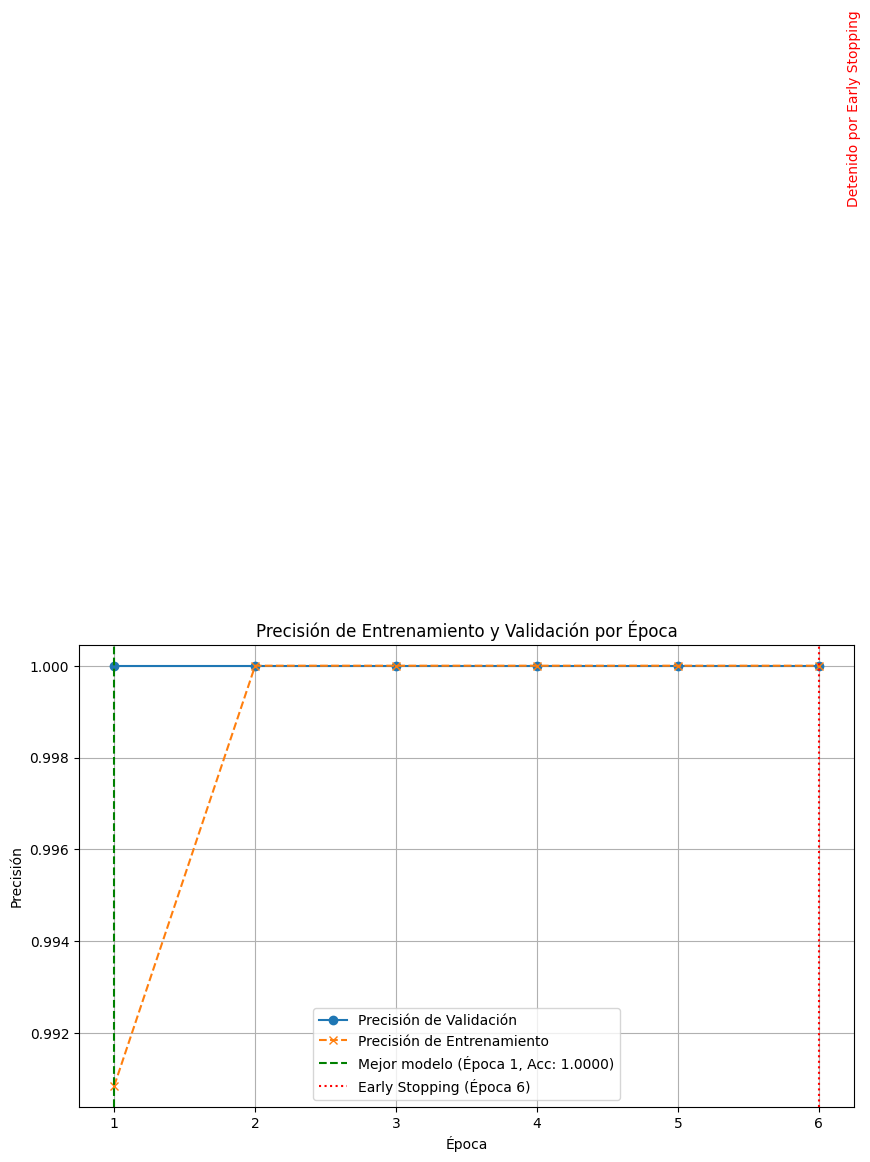


📈 Interpretación de la gráfica:

La gráfica muestra cómo la precisión del modelo evoluciona en los conjuntos de entrenamiento y validación a lo largo de las épocas.
- La línea 'Precisión de Entrenamiento' (azul, con 'x') indica el rendimiento del modelo en los datos con los que aprende.
- La línea 'Precisión de Validación' (naranja, con 'o') indica el rendimiento en datos no vistos durante el entrenamiento, lo cual es un indicador más fiable de la capacidad de generalización del modelo.
- La línea verde discontinua marca la época en la que el modelo obtuvo la mayor precisión en el conjunto de validación. Este es el punto en el que el modelo se considera 'mejor' porque generaliza mejor a datos nuevos.
- Si aparece una línea roja punteada, indica la época en la que el entrenamiento se detuvo prematuramente (Early Stopping). Esto sucede cuando la precisión de validación deja de mejorar durante un número predefinido de épocas ('patience'), evitando el sobreajuste.
En este caso, vemos que 

In [8]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Definir la función de pérdida (CrossEntropyLoss para clasificación multiclase).
criterion = nn.CrossEntropyLoss()
# Definir el optimizador (Adam) para ajustar los pesos del modelo durante el entrenamiento.
# lr es la tasa de aprendizaje, weight_decay es para regularización L2.
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Configuración de los parámetros de entrenamiento
EPOCHS = 25          # Número máximo de épocas de entrenamiento.
best_val_acc = 0.0   # Variable para guardar la mejor precisión de validación.
patience = 5         # Número de épocas a esperar si la precisión de validación no mejora (para Early Stopping).
patience_counter = 0 # Contador para el Early Stopping.

# Listas para almacenar las métricas de cada época (para la gráfica)
train_accuracies = []
val_accuracies = []

print("🚀 Iniciando entrenamiento...")

# Bucle principal de entrenamiento
for epoch in range(EPOCHS):
    # --- Fase de Entrenamiento ---
    model.train() # Poner el modelo en modo de entrenamiento (activa dropout, batchnorm, etc.).
    train_loss = 0.0
    train_preds, train_labels = [], []

    # Iterar sobre los lotes de datos del DataLoader de entrenamiento
    for inputs, labels_batch in train_loader:
        # Mover los datos de entrada y etiquetas al dispositivo (GPU/CPU).
        inputs, labels_batch = inputs.to(device), labels_batch.to(device)
        optimizer.zero_grad() # Limpiar los gradientes de la época anterior.
        outputs = model(inputs) # Realizar una pasada hacia adelante (forward pass).
        loss = criterion(outputs, labels_batch) # Calcular la pérdida.
        loss.backward()         # Realizar una pasada hacia atrás (backward pass) para calcular gradientes.
        optimizer.step()        # Actualizar los pesos del modelo con el optimizador.

        train_loss += loss.item() # Sumar la pérdida del lote.
        # Almacenar predicciones y etiquetas para calcular la precisión al final de la época.
        train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        train_labels.extend(labels_batch.cpu().numpy())

    # Calcular la precisión de entrenamiento de la época.
    train_acc = accuracy_score(train_labels, train_preds)
    train_accuracies.append(train_acc)

    # --- Fase de Validación ---
    model.eval() # Poner el modelo en modo de evaluación (desactiva dropout, etc.).
    val_preds, val_labels = [], []
    # Deshabilitar el cálculo de gradientes durante la validación para ahorrar memoria y computación.
    with torch.no_grad():
        # Iterar sobre los lotes de datos del DataLoader de validación.
        for inputs, labels_batch in val_loader:
            inputs, labels_batch = inputs.to(device), labels_batch.to(device)
            outputs = model(inputs) # Realizar una pasada hacia adelante.
            # Almacenar predicciones y etiquetas para calcular la precisión de validación.
            val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            val_labels.extend(labels_batch.cpu().numpy())

    # Calcular la precisión de validación de la época.
    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)

    # Imprimir los resultados de la época actual.
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss/len(train_loader):.4f} | "
          f"Train Acc: {train_acc:.4f} | "
          f"Val Acc: {val_acc:.4f}")

    # Lógica de Early Stopping: Guardar el mejor modelo y controlar la paciencia.
    if val_acc > best_val_acc:
        best_val_acc = val_acc # Actualizar la mejor precisión de validación.
        # Guardar los pesos del modelo si es el mejor hasta ahora.
        torch.save(model.state_dict(), "best_fire_model.pth")
        patience_counter = 0 # Reiniciar el contador de paciencia.
        best_epoch = epoch + 1 # Registrar la época del mejor modelo.
    else:
        patience_counter += 1 # Incrementar el contador si la precisión no mejora.
        if patience_counter >= patience:
            print("🔺 Early stopping activado.")
            early_stop_epoch = epoch + 1 # Registrar la época del early stopping.
            break # Detener el entrenamiento si se agota la paciencia.

print(f"✅ Mejor precisión en validación: {best_val_acc:.4f}")

# --- Gráfica de la precisión de validación --- #
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Precisión de Validación', marker='o')
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Precisión de Entrenamiento', marker='x', linestyle='--')

# Marcar la mejor época de validación
plt.axvline(x=best_epoch, color='g', linestyle='--', label=f'Mejor modelo (Época {best_epoch}, Acc: {best_val_acc:.4f})')

# Marcar la época de Early Stopping si ocurrió
if 'early_stop_epoch' in locals():
    plt.axvline(x=early_stop_epoch, color='r', linestyle=':', label=f'Early Stopping (Época {early_stop_epoch})')
    plt.text(early_stop_epoch + 0.2, min(val_accuracies) + 0.01, 'Detenido por Early Stopping', color='red', rotation=90, verticalalignment='bottom')

plt.title('Precisión de Entrenamiento y Validación por Época')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.xticks(range(1, len(val_accuracies) + 1))
plt.show()

print("\n📈 Interpretación de la gráfica:\n")
print("La gráfica muestra cómo la precisión del modelo evoluciona en los conjuntos de entrenamiento y validación a lo largo de las épocas.")
print("- La línea 'Precisión de Entrenamiento' (azul, con 'x') indica el rendimiento del modelo en los datos con los que aprende.")
print("- La línea 'Precisión de Validación' (naranja, con 'o') indica el rendimiento en datos no vistos durante el entrenamiento, lo cual es un indicador más fiable de la capacidad de generalización del modelo.")
print("- La línea verde discontinua marca la época en la que el modelo obtuvo la mayor precisión en el conjunto de validación. Este es el punto en el que el modelo se considera 'mejor' porque generaliza mejor a datos nuevos.")
print("- Si aparece una línea roja punteada, indica la época en la que el entrenamiento se detuvo prematuramente (Early Stopping). Esto sucede cuando la precisión de validación deja de mejorar durante un número predefinido de épocas ('patience'), evitando el sobreajuste.")
print("En este caso, vemos que la precisión de validación alcanzó su punto máximo en la Época {} y se mantuvo constante, por lo que el entrenamiento se detuvo por Early Stopping en la Época {}.".format(best_epoch, early_stop_epoch if 'early_stop_epoch' in locals() else 'final'))


## 🧪 8. Evaluación en el conjunto de prueba

📋 Reporte de clasificación (conjunto de prueba):
              precision    recall  f1-score   support

    No Fuego       1.00      1.00      1.00       112
       Fuego       1.00      1.00      1.00       218

    accuracy                           1.00       330
   macro avg       1.00      1.00      1.00       330
weighted avg       1.00      1.00      1.00       330



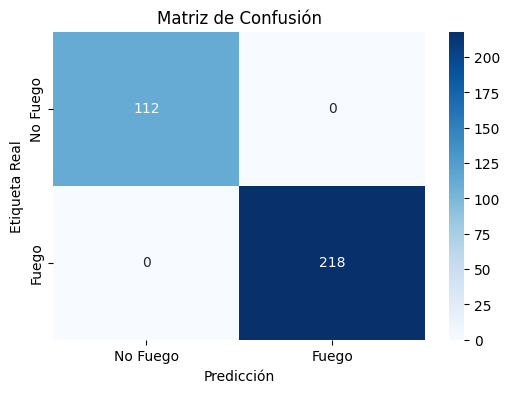

In [9]:
# Cargar los pesos del mejor modelo guardado durante el entrenamiento.
model.load_state_dict(torch.load("best_fire_model.pth"))
# Poner el modelo en modo de evaluación para la inferencia.
model.eval()

test_preds, test_labels = [], []
# Deshabilitar el cálculo de gradientes para la evaluación final en el conjunto de prueba.
with torch.no_grad():
    # Iterar sobre los lotes de datos del DataLoader de prueba.
    for inputs, labels_batch in test_loader:
        # Mover los datos al dispositivo (GPU/CPU).
        inputs, labels_batch = inputs.to(device), labels_batch.to(device)
        outputs = model(inputs) # Realizar una pasada hacia adelante.
        # Almacenar las predicciones y las etiquetas reales.
        test_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        test_labels.extend(labels_batch.cpu().numpy())

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Imprimir el reporte de clasificación, que incluye precisión, recall, f1-score y soporte por clase.
print("📋 Reporte de clasificación (conjunto de prueba):")
print(classification_report(test_labels, test_preds, target_names=["No Fuego", "Fuego"]))

# Calcular y visualizar la matriz de confusión.
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6,4))
# sns.heatmap crea un mapa de calor para la matriz de confusión, con anotaciones de los valores.
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Fuego", "Fuego"], yticklabels=["No Fuego", "Fuego"])
plt.title("Matriz de Confusión")
plt.ylabel("Etiqueta Real")
plt.xlabel("Predicción")
plt.show()